# Purpose

### 2021-10-29
In this notebook I'll upload the cluster labels for the current best model to bigQuery.

To recap coverage:
- 19k subreddits
    - 14k selected because they have the most activity (posts, views, & comments)
    - 5k of these are geo-relevant to i18n target markets (these have lower activity levels)

---

The best model logged in mlfow has this UUID:<br>
`134cefe13ae34621a69fcc48c4d5fb71`

# Imports & notebook setup

In [1]:
%load_ext google.colab.data_table

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# colab auth for BigQuery
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [4]:
# Attach google drive & import my python utility functions
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

import sys
l_paths_to_append = [
    '/content/gdrive/MyDrive/Colab Notebooks',

    # need to append the path to subclu so that colab can import things properly
    '/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n'
]
for path_ in l_paths_to_append:
    if not path_ in sys.path:
        print(f"Appending: {path_}")
        sys.path.append(path_)

Mounted at /content/gdrive
Appending: /content/gdrive/MyDrive/Colab Notebooks
Appending: /content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n


In [7]:
# install subclu & libraries needed to read parquet files from GCS

# !pip install -e "/content/gdrive/MyDrive/Colab Notebooks/subreddit_clustering_i18n/"

In [8]:
# Install needed to load data from GCS, for some reason not included in subclu?
# !pip install gcsfs

In [9]:
# !pip list

In [10]:
# Regular Imports
import os
from datetime import datetime

from google.cloud import bigquery

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2_unweighted, venn3_unweighted


os.environ['GOOGLE_CLOUD_PROJECT'] = 'data-prod-165221'

In [11]:
# subclu imports

# For reloading, need to force-delete some imported items
try:
    del LoadPosts, LoadSubreddits
except Exception:
    pass


from subclu.utils.hydra_config_loader import LoadHydraConfig
from subclu.data.data_loaders import LoadPosts, LoadSubreddits
from subclu.utils.eda import (
    setup_logging, counts_describe, value_counts_and_pcts,
    notebook_display_config, print_lib_versions,
    style_df_numeric, reorder_array,
)
from subclu.utils.data_irl_style import get_colormap
from subclu.models.clustering_utils import fancy_dendrogram


setup_logging()
print_lib_versions([pd, np])

python		v 3.7.12
===
pandas		v: 1.1.5
numpy		v: 1.19.5


# Load model labels

Ideally we could just pull the configuration data from github, but for now I'm just manually copying the artifact locations


In [62]:
# config_clust_v040 = LoadHydraConfig(
#     config_name='v0.4.0_2021_10_14-use_multi_lower_case_false_00',
#     config_path="../config/data_embeddings_to_cluster",
# )

In [13]:
run_uuid = '134cefe13ae34621a69fcc48c4d5fb71'
run_artifacts_uri = (
    'gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts'
)

gs_optimal_ks = f"{run_artifacts_uri}/optimal_ks/optimal_ks.parquet"
gs_model_labels = f"{run_artifacts_uri}/df_labels/df_labels.parquet"

In [61]:
# !gsutil ls $run_artifacts_uri

## optimal values for K (cluster number)

In [23]:
%%time
df_opt_ks = pd.read_parquet(gs_optimal_ks)
print(df_opt_ks.shape)

(7, 2)
CPU times: user 24.9 ms, sys: 1.13 ms, total: 26 ms
Wall time: 248 ms


## Labels for multiple values of k

We'll use the optimal values to filter out & keep only the labels we's use for One Feed.


Replace `predicted` to `majority` to show that the model is simply picking the majority lable, not really predicting it.

Rename column: `model_leaves_list_order_left_to_right` so that it's easier for people to understand and use. Maybe `model_distance_order`?

rename columns so that they don't start with a number, otherwise we'll get this bigQuery error:
```bash
GenericGBQException: Reason: 
    400 POST https://bigquery.googleapis.com/bigquery/v2/projects/reddit-employee-datasets/datasets/david_bermejo/tables: 

    Invalid field name "052_k_label". 
    Fields must contain only letters, numbers, and underscores, start with a letter or underscore, and be at most 300 characters long.
```

In [71]:
%%time
col_new_model_order = 'model_distance_order'
col_primary_topic_rename = 'primary_topic_0921'


df_labels_full = pd.read_parquet(gs_model_labels)

# Rename to standardize
df_labels_full = (
    df_labels_full
    # Rename predicted to majority
    .rename(columns={c: c.replace('-predicted-', '_majority_') for c in df_labels_full.columns})
    # label makes more sense than labels
    .rename(columns={c: c.replace('_k_labels', '_k_label') for c in df_labels_full.columns if c.endswith('_k_labels')})
    .rename(columns={
        'model_leaves_list_order_left_to_right': col_new_model_order,
        'primary_topic': col_primary_topic_rename,
        })
    .sort_values(by=[col_new_model_order], ascending=True)
)

# convert labels to proper dtype (integer)
l_cols_label_all = [c for c in df_labels_full.columns if c.endswith('_label')]
df_labels_full[l_cols_label_all] = df_labels_full[l_cols_label_all].astype(int)
del l_cols_label_all

df_labels_full['posts_for_modeling_count'] = df_labels_full['posts_for_modeling_count'].fillna(0).astype(int)

print(df_labels_full.shape)

(19053, 65)
CPU times: user 205 ms, sys: 32.9 ms, total: 238 ms
Wall time: 413 ms


In [72]:
df_labels_full.iloc[:10, :20]

,model_distance_order,subreddit_name,subreddit_id,primary_topic_0921,posts_for_modeling_count,010_k_label,014_k_label,020_k_label,030_k_label,040_k_label,050_k_label,052_k_label,060_k_label,070_k_label,080_k_label,090_k_label,100_k_label,110_k_label,120_k_label,130_k_label
2227,0,blackmetal,t5_2rta0,Music,1169,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
10817,1,metal,t5_2qhud,Music,1038,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4531,2,deathmetal,t5_2r5w5,Music,670,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
16920,3,thrashmetal,t5_2s66e,Music,285,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
16447,4,technicaldeathmetal,t5_2s8ge,Music,355,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
5046,5,doommetal,t5_2riaf,Music,715,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
13808,6,rabm,t5_2z5zk,Politics,167,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
13431,7,powermetal,t5_2qwe4,Music,607,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
13532,8,progmetal,t5_2s3pe,Music,812,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
13551,9,progrockmusic,t5_2s6xc,Music,697,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Filter to only k-optimal columns

Makes it easy to remove noise & understand cut-offs better

In [73]:
df_opt_ks

,k,col_prefix
010_to_020,14,014_k
020_to_050,30,030_k
050_to_100,52,052_k
100_to_200,100,100_k
200_to_300,248,248_k
300_to_400,351,351_k
400_to_600,405,405_k


In [75]:
l_cols_label_core = [
    col_new_model_order,
    'posts_for_modeling_count',
    'subreddit_id',
    'subreddit_name',
    col_primary_topic_rename,
]

cols_top_k = [c for c in df_labels_full.columns 
              if any(c.startswith(k_) for k_ in df_opt_ks[df_opt_ks['k'] >= 50]['col_prefix'].unique())
              ]

df_labels = (
    df_labels_full[l_cols_label_core + cols_top_k]
    .sort_values(by=[col_new_model_order], ascending=True)
).copy()


# move "k" to front so that we don't get bigQuery errors
df_labels = (
    df_labels
    .rename(columns={c: f"k{c.replace('_k_', '_')}" for c in df_labels.columns if '_k_' in c})
)

counts_describe(df_labels)

,dtype,count,unique,unique-percent,null-count,null-percent
model_distance_order,int64,"19,053","19,053",100.00%,0,0.00%
posts_for_modeling_count,int64,"19,053","1,175",6.17%,0,0.00%
subreddit_id,object,"19,053","19,053",100.00%,0,0.00%
subreddit_name,object,"19,053","19,053",100.00%,0,0.00%
primary_topic_0921,object,"15,929",51,0.32%,"3,124",16.40%
k052_label,int64,"19,053",52,0.27%,0,0.00%
k100_label,int64,"19,053",100,0.52%,0,0.00%
k248_label,int64,"19,053",248,1.30%,0,0.00%
k351_label,int64,"19,053",351,1.84%,0,0.00%
k405_label,int64,"19,053",405,2.13%,0,0.00%


# Check overall primary topic & clusters before uploading

Just a simple visual check before uploading.

In [76]:
value_counts_and_pcts(df_labels, col_primary_topic_rename, top_n=10)

,primary_topic_0921-count,primary_topic_0921-percent,primary_topic_0921-pct_cumulative_sum
nan,"3,124",16.4%,16.4%
Gaming,"2,472",13.0%,29.4%
Technology,"1,058",5.6%,34.9%
Internet Culture and Memes,816,4.3%,39.2%
Place,794,4.2%,43.4%
Music,680,3.6%,46.9%
Funny/Humor,655,3.4%,50.4%
Sports,542,2.8%,53.2%
Television,540,2.8%,56.1%
Mature Themes and Adult Content,520,2.7%,58.8%


### Check a few subs next to each other

If we sort by `model_distance_order` we should see the most similar subs next to each other as ranked by the hierarchical cluster model (`AgglomerativeCluster`).

:lol-cry: `christianmusic` gets grouped next to metal subs...

In [77]:
df_labels.head(20)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
2227,0,1169,t5_2rta0,blackmetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
10817,1,1038,t5_2qhud,metal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
4531,2,670,t5_2r5w5,deathmetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
16920,3,285,t5_2s66e,thrashmetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
16447,4,355,t5_2s8ge,technicaldeathmetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
5046,5,715,t5_2riaf,doommetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
13808,6,167,t5_2z5zk,rabm,Politics,1,1,1,1,1,Music,Music,Music,Music,Music
13431,7,607,t5_2qwe4,powermetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
13532,8,812,t5_2s3pe,progmetal,Music,1,1,1,1,1,Music,Music,Music,Music,Music
13551,9,697,t5_2s6xc,progrockmusic,Music,1,1,1,1,1,Music,Music,Music,Music,Music


In [78]:
df_labels.iloc[900:915, :]

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
1118,900,1200,t5_3ptom,arknights,Gaming,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
7308,901,1200,t5_39d7x,grandorder,Gaming,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
3352,902,136,t5_3fwwz,churchoffroppy,Anime,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
4488,903,1200,t5_3opwf,ddlc,Gaming,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
17155,904,1200,t5_2qvi5,touhou,Gaming,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
555,905,247,t5_3f073,alitabattleangel,Movies,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
18455,906,13,t5_25oi0m,whengamersfailsubb,None,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
648,907,218,t5_33toqa,ameliawatson,Funny/Humor,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
16520,908,200,t5_24d217,templeofmarianne,Gaming,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime
19004,909,418,t5_f4chf,zerotwo,Anime,2,4,8,10,10,Anime,Gaming,Gaming,Anime,Anime


In [79]:
df_labels.iloc[10000:10015, :]

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
16689,10000,1200,t5_30b6q,thedavidpakmanshow,None,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
14828,10001,686,t5_314b6,seculartalk,Politics,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
16760,10002,897,t5_36goq,themajorityreport,Podcasts and Streamers,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
13443,10003,207,t5_fpe3w,pragerurine,Internet Culture and Memes,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
4439,10004,527,t5_3a9fx,daverubin,Podcasts and Streamers,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
5577,10005,271,t5_kzpdl,enoughidwspam,Politics,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
7618,10006,1200,t5_qs1n3,hasan_piker,Activism,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
15158,10007,801,t5_3xjxn3,showinfrared,Podcasts and Streamers,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
1284,10008,329,t5_2yqo4,asklibertarians,Politics,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics
1218,10009,101,t5_2vg6d,askaconservative,None,23,40,105,149,169,Politics,Politics,Politics,Politics,Politics


In [80]:
df_labels.iloc[12000:12015, :]

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
13972,12000,88,t5_23h88r,realdebrid,Technology,30,54,141,200,236,Technology,Technology,Technology,Technology,Technology
17780,12001,106,t5_2qucj,usenet,Technology,30,54,141,200,236,Technology,Technology,Technology,Technology,Technology
11694,12002,198,t5_2yqfn,netgear,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
12495,12003,214,t5_3hfqg,orbi,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
7254,12004,258,t5_3ggya,googlewifi,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
7894,12005,1200,t5_2s4pd,homenetworking,None,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
18520,12006,264,t5_2rfxq,wifi,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
6615,12007,56,t5_kqaw8,fritzbox,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
11704,12008,107,t5_2qthw,network,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology
5375,12009,443,t5_36cnf,eero,Technology,30,54,142,201,237,Technology,Technology,Technology,Technology,Technology


In [81]:
df_labels.tail(15)

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
14923,19038,243,t5_2veuz,sexoffendersupport,Trauma Support,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
5769,19039,74,t5_2xrpd,excons,None,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
13503,19040,215,t5_2qvgf,prison,Law,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
15968,19041,60,t5_2qkzx,straightedge,None,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
6871,19042,893,t5_2t8ya,gangstalking,Medical and Mental Health,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
17332,19043,286,t5_2se6z,troubledteens,Activism,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
13299,19044,747,t5_2qhxd,police,Law,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
1280,19045,418,t5_33cpo,askle,Learning and Education,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
1281,19046,155,t5_2yogd,askleo,Law,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law
13301,19047,1000,t5_2xy00,policeuk,Law,52,100,248,351,405,"Business, Economics, and Finance",Law,Law,Law,Law


# Upload to BigQuery

In [82]:
df_labels.shape

(19053, 15)

In [83]:
run_uuid

'134cefe13ae34621a69fcc48c4d5fb71'

In [85]:
%%time

from datetime import datetime

(
    df_labels
    .assign(table_creation_date=datetime.utcnow().date())
    .assign(mlflow_run_uuid=run_uuid)
    .to_gbq(
        destination_table='david_bermejo.subclu_v0040_subreddit_clusters_c_a',
        project_id='reddit-employee-datasets',
        chunksize=500,
        if_exists='replace',
    )
)

500 out of 19053 rows loaded."
1000 out of 19053 rows loaded."
1500 out of 19053 rows loaded."
2000 out of 19053 rows loaded."
2500 out of 19053 rows loaded."
3000 out of 19053 rows loaded."
3500 out of 19053 rows loaded."
4000 out of 19053 rows loaded."
4500 out of 19053 rows loaded."
5000 out of 19053 rows loaded."
5500 out of 19053 rows loaded."
6000 out of 19053 rows loaded."
6500 out of 19053 rows loaded."
7000 out of 19053 rows loaded."
7500 out of 19053 rows loaded."
8000 out of 19053 rows loaded."
8500 out of 19053 rows loaded."
9000 out of 19053 rows loaded."
9500 out of 19053 rows loaded."
10000 out of 19053 rows loaded."
10500 out of 19053 rows loaded."
11000 out of 19053 rows loaded."
11500 out of 19053 rows loaded."
12000 out of 19053 rows loaded."
12500 out of 19053 rows loaded."
13000 out of 19053 rows loaded."
13500 out of 19053 rows loaded."
14000 out of 19053 rows loaded."
14500 out of 19053 rows loaded."
15000 out of 19053 rows loaded."
15500 out of 19053 rows loaded

CPU times: user 2.28 s, sys: 233 ms, total: 2.51 s
Wall time: 2min 39s


# Check specific subreddits (for fun)

hi team, quick update before the weekend: new table for clusters is now on bigQuery

`reddit-employee-datasets:david_bermejo.subclu_v0040_subreddit_clusters_c_a`

if you sort by `model_distance_order` you will get subreddits sorted by how close the model found them — so the subreddit right before and right after are the closest ones to the subreddit in the middle.

Next week Jennie and I will be working on how to reshape the data for QA, but here's a quick peek:

Finance cluster looks good:
We can see finance-related subreddits from multiple countries next to each other:
- `mexicofinanciero` -> Spanish, Mexico
- `beleggen` -> Dutch, Netherlands
- `finanzen` -> Germany
- `literaciafinanceira`, `investimentos`, -> Portuguese, Portugal
- `vosfinances` -> French, France
- `italiapersonalfinance` -> Italian, Italy
- `phinvest` -> English, Phillipines
- `malaysianpf` -> English, Malaysia


Clusters around France & Paris look decent.

In [93]:
l_subs_to_qa = [
    # 'christianmusic',
    # 'dune',
    # 'fussball',
    # 'de',
    'vosfinances',
    'france',
    # 'frenchrap',
    'mangafr',
    'paris',
]
n_subs_nearby = 4
for sub_name in l_subs_to_qa:
    sub_rank = df_labels.loc[df_labels['subreddit_name'] == sub_name, col_new_model_order].values[0]

    display(
        style_df_numeric(
            df_labels
            [df_labels[col_new_model_order].between(sub_rank - n_subs_nearby, sub_rank + n_subs_nearby, inclusive='both')]
            # .drop(['posts_for_modeling_count'], axis=1)
            ,
            l_bar_simple=[c for c in df_labels.columns if 'label' in c]
        )
    )

,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
10861,"18,919",630,t5_2rorh8,mexicofinanciero,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
1951,"18,920",90,t5_3jeou,beleggen,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
6160,"18,921","1,200",t5_35m5e,finanzen,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
9946,"18,922",600,t5_2clhc5,literaciafinanceira,None,52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
18145,"18,923",342,t5_37aoh,vosfinances,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
8571,"18,924",722,t5_38ilc,investimentos,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
8698,"18,925",638,t5_3isqn,italiapersonalfinance,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
12996,"18,926","1,044",t5_32eoz,phinvest,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"
10355,"18,927",261,t5_35kex,malaysianpf,"Business, Economics, and Finance",52,99,246,349,402,"Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance","Business, Economics, and Finance"


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
8454,"9,548",112,t5_484z6v,infos_france,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
18841,"9,549","1,200",t5_47quxa,yahooqr,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
925,"9,550",50,t5_2djd4u,antiracisme,"Culture, Race, and Ethnicity",23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6513,"9,551",111,t5_29145x,francedigeste,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6509,"9,552","1,200",t5_2qhjz,france,Place,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6510,"9,553",186,t5_4c3l03,france6,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
6511,"9,554",92,t5_48tn5k,francebbr,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
12757,"9,555",103,t5_2xe8t,paslegorafi,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place
10589,"9,556",552,t5_2xnq8,mayotte,None,23,38,100,141,160,Politics,Politics,Politics,Politics,Place


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
10397,553,"1,200",t5_3p7rg,mangacollectors,Anime,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10399,554,47,t5_4thzyd,mangade,"Reading, Writing, and Literature",2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10404,555,36,t5_35bgn0,mangaitalia,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10396,556,65,t5_2cdgea,manga_br,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
10402,557,"1,121",t5_ne3w4,mangafr,Anime,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
6034,558,488,t5_4ttqv7,feijoadanerdeotaku,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
861,559,285,t5_3nvds3,anitokio,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
4674,560,109,t5_4il4sl,designe,None,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime
837,561,454,t5_1465tr,animekisa,Art,2,3,5,6,6,Anime,Anime,Anime,Anime,Anime


,model_distance_order,posts_for_modeling_count,subreddit_id,subreddit_name,primary_topic_0921,k052_label,k100_label,k248_label,k351_label,k405_label,k052_majority_primary_topic,k100_majority_primary_topic,k248_majority_primary_topic,k351_majority_primary_topic,k405_majority_primary_topic
453,"17,645",79,t5_2tk47,aixmarseille,None,49,91,228,325,376,Place,Place,Place,Place,Place
7363,"17,646",79,t5_2skay,grenoble,None,49,91,228,325,376,Place,Place,Place,Place,Place
14425,"17,647",12,t5_3928f,rouen,None,49,91,228,325,376,Place,Place,Place,Place,Place
1263,"17,648",213,t5_2zkfk,askfrance,None,49,91,228,325,376,Place,Place,Place,Place,Place
12744,"17,649",399,t5_2qkoi,paris,Place,49,91,228,325,376,Place,Place,Place,Place,Place
2446,"17,650",24,t5_2stgm,bordeaux,None,49,91,228,325,376,Place,Place,Place,Place,Place
11838,"17,651",17,t5_3jgid,nicefrance,None,49,91,228,325,376,Place,Place,Place,Place,Place
14146,"17,652",14,t5_2tx5n,rennes,None,49,91,228,325,376,Place,Place,Place,Place,Place
11552,"17,653",21,t5_2sq2i,nantes,None,49,91,228,325,376,Place,Place,Place,Place,Place


# Show Dendrogram at n=52

## Load linkage data

In [52]:
# !gsutil ls $run_artifacts_uri

In [53]:
path_gs_linkage = f"{run_artifacts_uri}/X_linkage"

!gsutil ls $path_gs_linkage

gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/X_linkage/X_linkage.csv
gs://i18n-subreddit-clustering/mlflow/mlruns/18/134cefe13ae34621a69fcc48c4d5fb71/artifacts/X_linkage/X_linkage.parquet


In [54]:
%%time

X_linkage = pd.read_parquet(
    f"{path_gs_linkage}/X_linkage.parquet"
)
print(X_linkage.shape)

(19052, 4)
CPU times: user 44.1 ms, sys: 9.15 ms, total: 53.3 ms
Wall time: 371 ms


## Show dendrogram

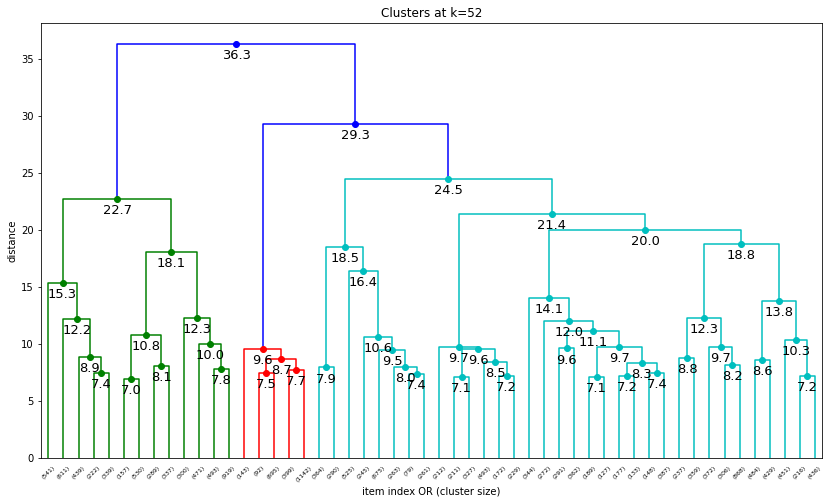

In [56]:
p_ = 52
fancy_dendrogram(
    X_linkage,
    plot_title=f"Clusters at k={p_}",
    annotate_above=X_linkage['distance'].quantile(q=0.985),
    truncate_mode='lastp',
    p=p_,
    orientation='top',
    show_leaf_counts=True, leaf_rotation=45,
    # show_contracted=False,
    # color_threshold=15.3,
)
plt.show()